# Importing libraries

In [1]:
#R
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import gensim
import pickle
import random
import itertools
import warnings
warnings.filterwarnings('ignore')

C:\Users\lenovo\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#R
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.cluster import KMeansClusterer, cosine_distance
from sklearn.metrics.pairwise import cosine_similarity

# Load data

In [4]:
#R
data=pd.read_csv('news_articles.csv')['Content']

In [5]:
#R
data.head(),len(data)

(0    At least 14 people died and 17 others were inj...
 1    TV actress Pratibha Tiwari  who is best known ...
 2    The United States and South Korea began a join...
 3    The relentless drive by Bengaluru s  Bangalore...
 4    Punjab Gau Raksha Dal chief Satish Kumar and h...
 Name: Content, dtype: object, 4831)

In [9]:
#R
len_a=[]
for i in data:
    len_a.append(len(i))

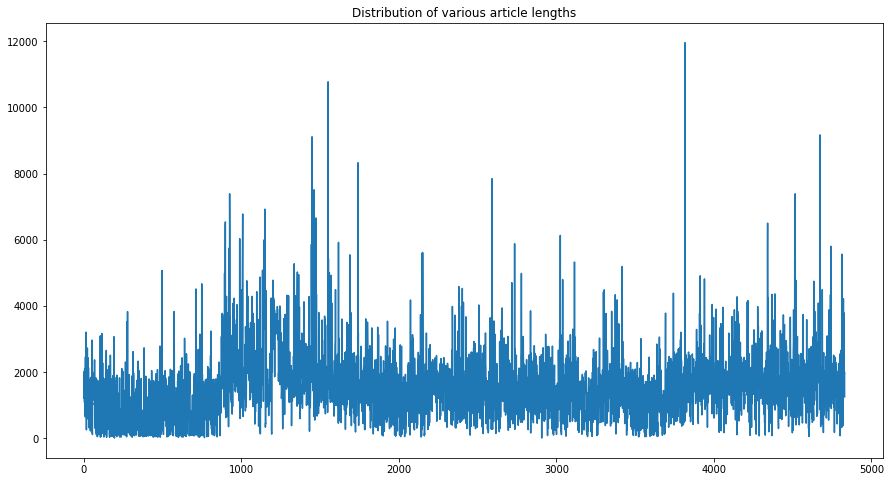

In [15]:
#R
plt.figure(figsize=(15,8))
plt.title("Distribution of various article lengths")
plt.plot(len_a)

# Data cleaning :

# 1.remove numbers:

# 2.nlp operations:

In [19]:
#R
#load files
cleaned_data=pickle.load(open('cleaned_data.pkl','rb'))

# tfidf function

In [18]:
#R
vectorizer=TfidfVectorizer()
def tfidf_scores(d):
    tfidf=vectorizer.fit_transform(d)
    return tfidf

In [20]:
#R
n_data=[]
for i in cleaned_data:
    n_data.append(' '.join(i))
new_data=pd.Series(n_data)    
scores=tfidf_scores(n_data)

# Topic modelling

# clustering articles

In [21]:
#R
d2v=pickle.load(open('d2v.pickle','rb'))

# data generation

In [23]:
#R
# avg. reading speed (200 wpm,source: INTERNET)
speed=200

In [24]:
#R
l=[]
for i in data:
    l.append(np.array(i.split()).shape[0])
#avg. length of doc (no. of words)
avg_length=np.average(l)

In [25]:
#R
avg_time =avg_length/speed
avg_time*60 #in seconds 

80.391989236183

In [26]:
#R
clt_articles=pickle.load(open('cluster.pickle','rb'))

def generate_data(aid):
    #Generate clickstream data 
    click_stream=np.random.binomial(1,0.75,500)
    
    # Generate time sample from three gaussian distributions
    time = np.random.normal(5,0.5,60)      # just opened and closed
    time = np.append(time, np.random.normal(30,10,160))  # read half/some part   
    time = np.append(time, np.random.normal(80,10,270))   # read completely
    time = np.append(time, np.random.normal(200,10,10))  # app left apened etc.
    #generate 10 values for time
    new_time=time.reshape(-1,1)*click_stream.reshape(-1,1)  
    read_time=random.sample(list(new_time.ravel()),10)
    click=np.ones((len(read_time),1))
    for i in range(len(read_time)):
        if read_time[i]==0:
            click[i]=0
    
    #generating 10 random articles from corpus
    if len(aid)==0:
        aid=[]
        for i in range(10):
            aid.append(random.sample(list(itertools.chain.from_iterable(clt_articles[i])),1)[0])  
    
    #sort aid based on time        
    read_time=np.array(read_time)
    n_liked=len(set(read_time[read_time>50]).intersection(set(read_time[read_time<150])))
    sorted_=[x for _,x in sorted(zip(read_time,aid),reverse=True)]
    liked_=[x for _,x in sorted(zip(read_time,aid),reverse=True)][:n_liked]
    
    #calculating a_rnk and liked articles
    rnk={}
    for j in range(len(sorted_)):
        rnk[sorted_[j]]=j+1    
    a_rnk=[]
    liked=np.zeros((10,1))
    for k in range(len(aid)):
        a_rnk.append(rnk[aid[k]])
        if aid[k] in liked_:
            liked[k]=1
    
    
    return aid,read_time,click,a_rnk,liked


In [27]:
#R
class user():
    id_generator = itertools.count(1)
    def __init__(self,name,article):
        self.name=name
        self.id =next(self.id_generator)
        #self.sid=session
        self.aid,self.time,self.click,self.a_rnk,self.liked=generate_data(article)
    

In [28]:
#R
def user_data(session_id,articles):
    
    if len(articles)!=0:
        user1=user('u1',articles[0])
        user2=user('u2',articles[1])
        user3=user('u3',articles[2])
        user4=user('u4',articles[3])
        user5=user('u5',articles[4])
    else:
        user1=user('u1',[])
        user2=user('u2',[])
        user3=user('u3',[])
        user4=user('u4',[])
        user5=user('u5',[])

    #creating a dataframe for user profiling
    up=pd.DataFrame()
    uid=[]
    aid=[]
    time=[]
    click=[]
    a_rnk=[]
    liked=[]
    
    user_names=[user1,user2,user3,user4,user5]    
    
    for s in range(session_id):
        if s==0:
            for names in user_names:
                uid.append([names.id]*10)
                aid.append(names.aid)
                time.append(names.time)
                click.append(names.click)
                a_rnk.append(names.a_rnk)
                liked.append(names.liked)
                
        else:    
            for n,names in enumerate(user_names): 
                aid_,time_,click_,a_rnk_,liked_=generate_data([])
                uid.append([names.id]*10)
                aid.append(aid_)
                time.append(time_)
                click.append(click_)
                a_rnk.append(a_rnk_)
                liked.append(liked_)
            
    up['uid']=np.array(uid).ravel()
    up['sid']=np.sort(list(range(1,session_id+1))*50)
    up['aid']=np.array(aid).reshape(-1,1)
    up['time']=np.array(time).reshape(-1,1)
    up['click']=np.array(click).reshape(-1,1)
    up['a_rnk']=np.array(a_rnk).reshape(-1,1)
    up['liked']=np.array(liked).reshape(-1,1)

    return up

In [29]:
#R
# similarity function
def similar(d2v,liked,n):
    cos_sim=cosine_similarity(d2v,liked)
    return cos_sim.ravel().argsort()[-(n+1):-1][::-1]

In [30]:
#R
d2v=pickle.load(open('d2v.pickle','rb'))
data=pickle.load(open('user_data.pickle','rb'))
mean_time=data.groupby('aid').mean()['time']

# User data has 7 fields:
### 1.uid: user id.
### 2.sid: session id.
### 3.aid: id of article given to user. 
### 4.time: time spent by user on that article.
### 5.click: whether user read that article(yes or no).
### 6.a_rnk: rank of article amongst all the articles given to user(acc. to liking).
### 7.liked: whether user liked that article.


In [31]:
#R
data.head()

,uid,sid,aid,time,click,a_rnk,liked
0,1,1,228,5.563829,1.0,6,0.0
1,1,1,256,68.773441,1.0,2,1.0
2,1,1,606,0.000000,0.0,9,0.0
3,1,1,4633,52.278529,1.0,3,1.0
4,1,1,1326,96.003458,1.0,1,1.0


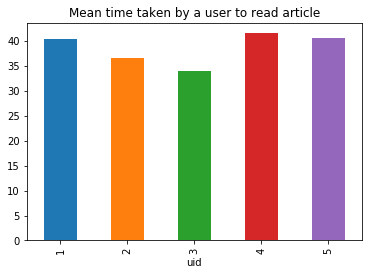

In [43]:
plt.title("Mean time taken by a user to read article")
data.groupby(['uid'])['time'].mean().plot(kind='bar')

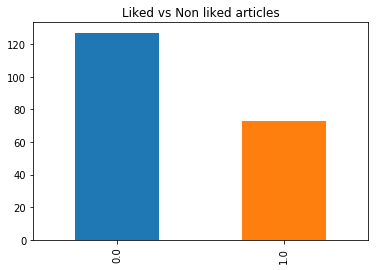

In [37]:
plt.title("Liked vs Non liked articles")
data.liked.value_counts().plot(kind='bar')

# Recommender function

In [49]:
#R
def new(data,d2v):
    
    #average vector of every user /user profile
    profile=[]
    for j in range(5):
        temp=[]
        for i in data.loc[(data['uid'] ==j+1) & data['liked']==1]['aid'] :    
            weight=int((data[data['aid']==i]['time']/mean_time[i]).values[0])
            temp.append(d2v[i]*weight)  
        profile.append(np.mean(temp,axis=0)) 

    #based on all users (2)
    all_avg=np.mean(profile,axis=0)  #average vector from all users
    trending=similar(d2v,all_avg.reshape(1,-1),2)
    

    #based on user's history (6)
    #content based filtering
    history=[]
    for vector in profile:
        history.append(similar(d2v,vector.reshape(1,-1),6))
    

    #based on similar users (2)
    #collaborative filtering
    sim_users=np.ones((5,5))
    for i in range(len(profile)):
        for j in range(len(profile)):
            sim_users[i][j]=cosine_similarity(profile[i].reshape(1,-1),profile[j].reshape(1,-1))
    sim_users=sim_users.argsort()[:,-3:-1] 
    #print(sim_users)

    #articles based on similar users 
    sim_art=[]
    for i,j in sim_users:
        temp=[]
        temp.append(profile[i])
        temp.append(profile[j])
        sim_art.append(similar(d2v,np.mean(np.array(temp),axis=0).reshape(1,-1),2))
    #return history,sim_art,trending
    new_aid=[]
    for i in range(5):
        temp=[]
        temp.extend(history[i])
        temp.extend(sim_art[i])
        temp.extend(trending)

        new_aid.append(temp)

    return new_aid

In [50]:
new_articles=new(data,d2v)

In [51]:
def show_new(new_articles):
    d=pd.DataFrame(columns=['uid','sid','aid','time','click','a_rnk','liked'])
    uid=[]
    sid=[]
    aid=[]
    time=[]
    click=[]
    a_rnk=[]
    liked=[]
    for n in range(5):
        uid.append([n+1]*10)
        sid.append([6]*10)
        aid.append(new_articles[n])
        time.append(['-']*10)
        click.append(['-']*10)
        a_rnk.append(list(range(1,11)))
        liked.append(['-']*10)
    d['uid']=np.array(uid).ravel()
    d['sid']=np.array(sid).ravel()
    d['aid']=np.array(aid).ravel()
    d['time']=np.array(time).ravel()
    d['click']=np.array(click).ravel()
    d['a_rnk']=np.array(a_rnk).ravel()
    d['liked']=np.array(liked).ravel()
    return d

# 5 articles recommended to user 1 for next session

In [52]:
show_new(new_articles).head()

,uid,sid,aid,time,click,a_rnk,liked
0,1,6,1474,-,-,1,-
1,1,6,898,-,-,2,-
2,1,6,1456,-,-,3,-
3,1,6,1008,-,-,4,-
4,1,6,4822,-,-,5,-


In [53]:
d_articles=pd.read_csv('news_articles.csv')['Content']

# Let's test our recommender bot

In [56]:
from wordcloud import WordCloud,STOPWORDS

def cloud(text):
    word=WordCloud(stopwords=STOPWORDS).generate(text)
    plt.imshow(word)
    

## Following article was liked by user 1:

In [66]:
d_articles[1326][:2000]

'Apple s pressure-sensitive 3D Touch integration in the iPhone 6s series could be seen in a wide range of smartphones this year  While rumours have pointed towards a possibility of a 3D Touch-like feature in Google s upcoming Android N OS  HTC is reportedly planning to include a 3D Touch display in the next Nexus smartphone \nAccording to GizmoChina  an industry insider confirmed pressure-sensitive displays will be seen in more and more devices as companies like Xiaomi  Meizu  Oppo and Vivo are already developing the tech  Almost all major Chinese tech companies are expected to follow the trend  and rumours already suggest Meizu s upcoming MX6 flagship will be one of the devices to demonstrate the new display technology in the next few months \n\n\nIn the current market  Apple isn t the only one to feature 3D Touch displays  A handful of companies has already demonstrated similar capabilities  Gionee S8  launched at MWC 2016  features 3D Touch technology and Huawei introduced pressure-

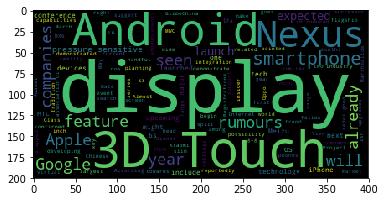

In [60]:
text=d_articles[1326]
cloud(text)

## Based on that, following are recommended:

In [64]:
d_articles[1474][:2000]

'When Samsung released their Note series by bringing in the phablet devices  every big smartphone manufacturer including Apple and HTC preferred to stick to smaller devices \nSurprisingly  years later  all of them silently started following this big screen design language with their own signature terms  Samsung combined a big impressive screen with Wacom precision input through a stylus  which became outdated by the time first Galaxy Note device arrived  Samsung truly showed how a stylus can seriously improve your smartphone usage by mixing some creative pinch of fun into it \n\n\nSamsung Galaxy Note 4  the 4th generation of Note devices arrived with an array of hardware and software features  which can be criticised  but tough to ignore  Anyways  once the Note 4 debuted in the country we decided to start using it extensively for some time  before passing any judgment  Rather than writing a very conventional review with traditional sections  we have tried to make it interactive by disc

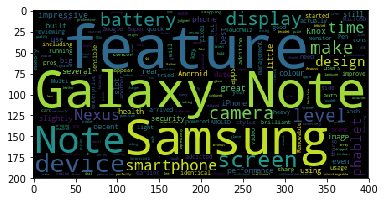

In [57]:
text=d_articles[1474]
cloud(text)

In [65]:
d_articles[898][:2000]

'Xiaomi s previous generation Redmi Note series had received a tremendous response in India as it came with top notch features  and there was hardly any competition to match it in the budget segment  Now  Xiaomi  in a bid to further get a grip on the budget phone segment  has introduced the well-crafted Redmi Note 3  which not only focuses on performance and battery life  but also on design language  photography and security \nWe have been using Redmi Note 3 for more than three weeks and it has impressed in almost all aforementioned aspects \n\n\nHere s our take on Redmi Note 3 \nDesign and build quality  4 5 5  \nMost of previous Xiaomi devices used to boast top-end internal hardware but were visually not so appealing  However  in 2016  Xiaomi has done a great job with the new phablet  The Redmi Note 3  in our opinion  is the best looking mid-range device out there in the Indian market \nThe new phablet features metal-based unibody design and is curvier compared to its predecessor  On

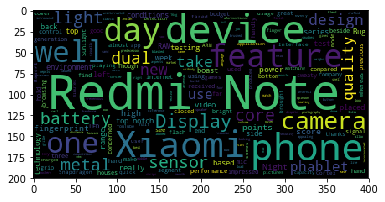

In [59]:
text=d_articles[898]
cloud(text)

# CONCLUSION:
## So, we can see that our recommender bot is doing a great job here.
## If you have any suggestions or doubts, please do tell.


# Thanks